<a href="https://colab.research.google.com/github/HyeonjongJang/fashion_MNIST/blob/main/mnist1_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

keras에서 제공하는 데이터셋은 boston_housing(보스턴 집값 예측), cifar(이미지 분류), mnist(손글씨 분류), fashion_mnist(의류 분류), imdb(영화 리뷰 감정 분류), reuters(뉴스 토픽 분류)가 존재한다.

In [1]:
import tensorflow as tf
from tensorflow import keras

import keras.datasets as d
help(d)

Help on package keras.datasets in keras:

NAME
    keras.datasets - Small NumPy datasets for debugging/testing.

PACKAGE CONTENTS
    boston_housing
    cifar
    cifar10
    cifar100
    fashion_mnist
    imdb
    mnist
    reuters

FILE
    /usr/local/lib/python3.10/dist-packages/keras/datasets/__init__.py




fashion mnist 데이터를 train, test set으로 나누어 불러 왔다. train set은 6만장, test set은 1만장의 데이터로 이루어져 있다. 각 데이터는 28*28의 pixel로 이루어져 있다. 

y label은 0부터 9까지의 숫자로 이루어져있는데, 각 라벨은 아래와 같은 의미를 가진다.

0 : T-shirt/top

1 : Trouser

2 : Pullover

3 : Dress

4 : Coat

5 : Sandal

6 : Shirt

7 : Sneaker

8 : Bag

9 : Ankel boot

In [2]:
fmnist = keras.datasets.fashion_mnist
(X_train,y_train),(X_test,y_test) = fmnist.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


각 데이터를 대략적으로 판단하기 위해 train set에서 15장(3행 5열)로 골라서 시각화. 

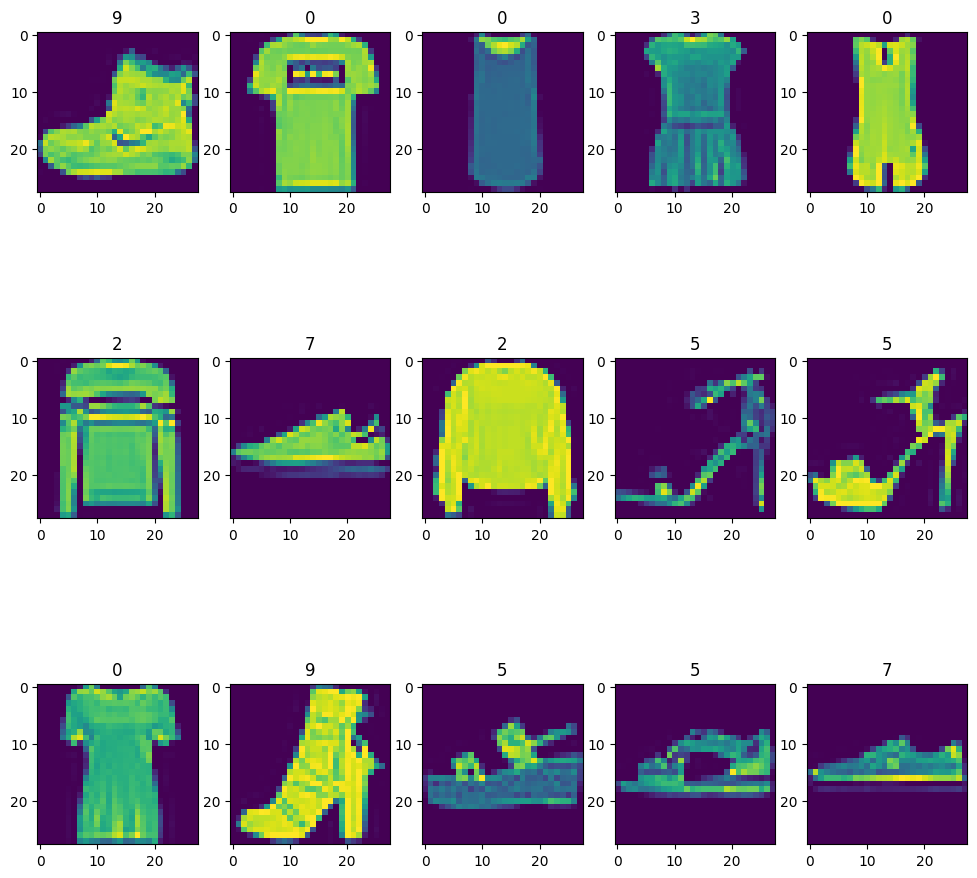

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.title(y_train[i])
    plt.imshow(X_train[i])
  

CNN 모델의 input은 4개의 차원 (행의 개수, width, height, channel 수)로 들어가야 하기에, 위에서 X_train.shape에서 (60000, 28, 28)의 구조는 그대로 유지시키고, 이 데이터는 흑백 데이터이므로 channel = 1의 차원을 추가.

X_train.reshape(len(X_train), 28, 28, 1)로 구현할 수 있고, X_train[:, :, :, np.newaxis]로도 (60000, 28, 28, 1)의 shape을 구현할 수 있다. 

각 pixel 값이 0에서 255 사이의 숫자이므로 X_train과 X_test를 모두 255로 나누어 마찬가지로 정규화를 수행.

In [4]:
import numpy as np
X_train2 = X_train[:,:,:,np.newaxis] #차원 증가(3차원으로, reshape의 효과)
X_test2 = X_test[:,:,:,np.newaxis]

X_train2 = X_train2/255
X_test2 = X_test2/255

y는 0에서 9사이의 숫자를 갖는 라벨값으로, keras의 분류 모델은 one hot encoding이 되어야 하므로  to_categorical로 [0, 1, 0, ... , 0]의 라벨을 새로 만들어 진행.

In [5]:
from tensorflow.keras.utils import to_categorical

y_train2 = to_categorical(y_train,10)
y_test2 = to_categorical(y_test,10)

fashion mnist data는 mnist에 비해 이미지의 특징적인 것들이 많으므로 Conv2D -> maxpooling을 반복하면서 노이즈를 제거했다. Flatten, FC layer들을 거치고 Dropout을 시켜 모델을 생성.

In [7]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.layers.convolutional import Conv2D,MaxPooling2D

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size=(3,3),strides=(1,1),padding='Same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size=(3,3),strides=(1,1),padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size=(3,3),strides=(1,1),padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) : 모델 컴파일을 위한 행. loss 인자는 손실 함수로 categorical_crossentropy를 사용하며, optimizer는 최적화 알고리즘으로 'adam'을 사용. metrics는 모델의 평가 지표로 정확도를 사용.

model.summary() : 모델의 구조와 매개변수 개수 등의 정보를 요약해서 출력.

In [10]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 32)        

loss: 0.25
accuracy: 0.917

cnn을 사용했을 때 정확도가 상승하는 것을 확인할 수 있었다.

In [14]:
hist = model.fit(X_train2,y_train2,epochs =5 , batch_size=100,verbose=2)
loss,acc = model.evaluate(X_test2,y_test2)
print('loss:', round(loss,3))
print('accurate:', round(acc,3))

Epoch 1/5
600/600 - 52s - loss: 0.1878 - accuracy: 0.9334 - 52s/epoch - 86ms/step
Epoch 2/5
600/600 - 53s - loss: 0.1769 - accuracy: 0.9374 - 53s/epoch - 88ms/step
Epoch 3/5
600/600 - 51s - loss: 0.1666 - accuracy: 0.9398 - 51s/epoch - 86ms/step
Epoch 4/5
600/600 - 52s - loss: 0.1550 - accuracy: 0.9437 - 52s/epoch - 86ms/step
Epoch 5/5
600/600 - 52s - loss: 0.1462 - accuracy: 0.9464 - 52s/epoch - 86ms/step
313/313 [==============================] - 3s 8ms/step - loss: 0.2502 - accuracy: 0.9174
loss: 0.25
accurate: 0.917
